# new 方法: stage1 & stage2

In [1]:
import sys
sys.path.append("..")

import pandas as pd
from models import Yolov4
from tensorflow import keras
from config import yolo_config
from iou import get_iou, calculate_ciou
from utils import DataGenerator, read_annotation_lines

import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import seaborn as sns
from turtle import color
from matplotlib import style
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import math
import cv2 as cv
import xml.etree.ElementTree as ET

import pickle

import os
# 使用第二張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 載入模型

In [2]:
# yolo_config['score_threshold']=0.7
# print(yolo_config)

In [3]:
import warnings
warnings.filterwarnings('ignore')
class_name_path = '../class_names/classes.txt'
model = Yolov4(
               weight_path    =None, 
               config         =yolo_config,
               class_name_path=class_name_path, 
               )
model.load_weights(path="../model/202211/20221104_2_sopbox_0.weights")            # 換stage2模型

#1102是沒有10%背
#1104是有10%背景

2023-02-18 15:21:53.237146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 15:21:53.245140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 15:21:53.245909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 15:21:53.246925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

nms iou: 0.0 score: 0.0


# 每一個test image "True" bounding box

In [4]:
true_box_PATH = '../test_dataset/txt/20221102_anno_test_lines_0.txt'       # 這邊要修改train/test 的路徑!!!!!!!!
# true_box_PATH = '../dataset/txt/20221102_anno_train_lines_0.txt'
# true_box_PATH = '../dataset/txt/20221102_anno_val_lines_0.txt'


true_bboxes_names = []
true_bboxes_list  = []
with open(true_box_PATH) as f:
    for line in f.readlines():
        true_bboxes_list.append(tuple([int(i) for i in line.split(' ')[1].split(',')[:4]]))
        true_bboxes_names.append(line.split(' ')[0])
        

In [5]:
true_bboxes = pd.DataFrame({'test_name':true_bboxes_names, 
                            'true_bbox':true_bboxes_list
                            })
true_bboxes

,test_name,true_bbox
0,h_000048.png,"(432, 24, 659, 281)"
1,h_000049.png,"(273, 19, 529, 297)"
2,h_000050.png,"(202, 99, 442, 358)"
3,h_000051.png,"(139, 288, 367, 573)"
4,h_000053.png,"(113, 259, 359, 560)"
...,...,...
184,z_000077.png,"(169, 6, 636, 604)"
185,z_000078.png,"(205, 34, 685, 611)"
186,z_000079.png,"(202, 30, 687, 606)"
187,z_000080.png,"(189, 35, 680, 618)"


# 每一個test image "Pred" bounding box

In [6]:
train = ['a', 'b', 'c', 'e', 'f', 'g', 'j', 'm', 'n', 'p', 'r', 's', 't', 'u']
val   = ['d', 'i', 'k', 'o']
test  = ['h', 'l', 'q', 'z']

# PATH = '../../classification/dataset_smooth_22video_20221031/test/1/'
PATH = '../../classification/dataset_22video_20221031/test/1/'
# PATH = '../../classification/dataset_smooth_22video_20221031/train/1/'            # 這邊要修改train/test 的路徑!!!!!!!!
# PATH = '../../classification/dataset_smooth_22video_20221031/validation/1/'       # 這邊要修改train/test 的路徑!!!!!!!!

pred_bboxes_names  = []  # all image names
pred_bboxes_scores = []  # all bboxes scores
pred_bboxes_list   = []  # all bboxes
for test_img_name in true_bboxes['test_name']:  # glob(os.path.join(PATH, '*.png')):
    test_img_path = PATH + test_img_name
    output_img, detections = model.predict(img_path=test_img_path, 
                                        random_color=False, # 框顏色
                                        plot_img=False, # 顯示出框選圖片
                                        show_text=True, # 框上面加上類別文字
                                        box_num=1,      # 顯示框的數量
                                        return_output=True)
    
    limit = 1 #len(detections['score'])                            # 這邊要修改無限制 / 限制數量1個  !!!!!!!!!!!
    pred_box_num = len(detections['score'])  
    print("pred_box_num= ",pred_box_num)                    
    if pred_box_num > 0:       # 有預測出box
        for i in range(limit):
            score = detections[i:i+1]['score'].to_numpy()[0]
            print("score = ",score)
            if score >= 0.0:                                        # 這邊放寬score限制，看混淆矩陣狀況 !!!!!!!!!!! 
                pred_bboxes_names.append(test_img_name)
                pred_bboxes_scores.append(score)
                pred_bboxes_list.append(tuple(detections[i:i+1][['x1','y1','x2','y2']].to_numpy()[0]))

            else:
                pred_bboxes_names.append(test_img_name)
                pred_bboxes_scores.append(score)
                pred_bboxes_list.append('NO')
    else:
        pred_bboxes_names.append(test_img_name)
        pred_bboxes_scores.append(0.0)
        pred_bboxes_list.append('NO')
        print('沒有預測出來有box(label)')

2023-02-18 15:22:08.965693: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


1/1 [==============================] - 2s 2s/step
# of bboxes: 1
pred_box_num=  1
score =  0.4820204
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.48288953
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.50004613
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.4443309
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.40267068
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.3987674
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.55264425
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.5749171
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.28686026
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pre

In [7]:
pred_bboxes = pd.DataFrame({'test_name':pred_bboxes_names, 
                            'pred_bbox':pred_bboxes_list,
                            'score':pred_bboxes_scores
               })
pred_bboxes

,test_name,pred_bbox,score
0,h_000048.png,"(359, 64, 728, 560)",0.482020
1,h_000049.png,"(161, 0, 726, 631)",0.482890
2,h_000050.png,"(163, 24, 500, 513)",0.500046
3,h_000051.png,"(184, 0, 697, 556)",0.444331
4,h_000053.png,"(96, 182, 422, 585)",0.402671
...,...,...,...
184,z_000077.png,"(130, 57, 631, 578)",0.593118
185,z_000078.png,"(191, 51, 663, 576)",0.665601
186,z_000079.png,"(188, 52, 662, 573)",0.645374
187,z_000080.png,"(160, 28, 620, 608)",0.653640


# perfect stage2 prediction result

In [8]:
stage2_pred_result = true_bboxes.merge(pred_bboxes, on=['test_name'], how='left')

In [9]:
stage2_pred_result

,test_name,true_bbox,pred_bbox,score
0,h_000048.png,"(432, 24, 659, 281)","(359, 64, 728, 560)",0.482020
1,h_000049.png,"(273, 19, 529, 297)","(161, 0, 726, 631)",0.482890
2,h_000050.png,"(202, 99, 442, 358)","(163, 24, 500, 513)",0.500046
3,h_000051.png,"(139, 288, 367, 573)","(184, 0, 697, 556)",0.444331
4,h_000053.png,"(113, 259, 359, 560)","(96, 182, 422, 585)",0.402671
...,...,...,...,...
184,z_000077.png,"(169, 6, 636, 604)","(130, 57, 631, 578)",0.593118
185,z_000078.png,"(205, 34, 685, 611)","(191, 51, 663, 576)",0.665601
186,z_000079.png,"(202, 30, 687, 606)","(188, 52, 662, 573)",0.645374
187,z_000080.png,"(189, 35, 680, 618)","(160, 28, 620, 608)",0.653640


# 計算iou 繪圖
參數:
iou_threshold = 0.7    "iou大於0.7才是有框選到"

In [10]:
def valid(TP, FN, FP, TN):
    
    precision = 0 if (TP+FP)==0 else TP/(TP+FP)
    recall    = 0 if (TP+FN)==0 else TP/(TP+FN)
    f1        = 0 if (precision+recall)==0 else 2*precision*recall/(precision+recall)

    print('precision={:.2f}, recall={:.2f}, f1={:.2f}'.format(precision, recall, f1))
    print(TP,"|",FN,"\n",
          FP,"|",TN)

    return precision, recall, f1

In [11]:
def plt_precision_recall_curve_1(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    average_precision             = average_precision_score(y_true, y_scores)
    # 用套件畫
    # disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    # disp.plot()
    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    # plt.show()

    # 自己畫
    plt.plot(recall, precision, 'b-')   
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])  
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision_recall_curve')
    plt.legend(['AP={}'.format(round(average_precision,2))])
    plt.show()

    # print('precision = ', precision)
    # print('recall = ', recall)
    # print('thresholds = ',thresholds)
    print('AP={:.2f}'.format(average_precision))

In [12]:
def plt_heatmap(con_ma):
    '''
    :input: con_ma:[[TP,FN],[FP,TN]]
    '''
    sns.set(font_scale=1.5)
    f,ax=plt.subplots()
    sns.heatmap(con_ma, annot=True, ax=ax, fmt='d', cmap='YlGnBu', vmax=200, vmin=0) # 畫熱力圖
    ax.set_title('confusion matrix') # 標題
    ax.set_xlabel('predict')         # x軸
    ax.set_ylabel('true')            # y軸
    ax.xaxis.set_ticklabels(['Papilla', 'No Papilla'])
    ax.yaxis.set_ticklabels(['Papilla', 'No Papilla'])
    plt.show()

perfect stage2 測試集結果 固定iou_threshold=0.5
這沒有參考價值，因為要限制score

In [13]:
# row, col = stage2_pred_result.shape
# iou_thresholds = np.arange(0.5, 0.6, 0.1)      # 固定ciou_threshold=0.5
# # test_img_names = true_bbox.keys()
# precisions, recalls, f1s = [], [], []
# for iou_threshold in iou_thresholds:
#     TP,FP,FN,TN = 0,0,0,0
#     y_true  = []                 # 0:無壺腹乳頭 1:有壺腹乳頭
#     y_score = []                 # confidence分數
#     for r in range(row):                # row: 列數
#         test_img_name = stage2_pred_result.iloc[r:r+1]['test_name'][r]
#         true_bbox     = stage2_pred_result.iloc[r:r+1]['true_bbox'][r]
#         pred_bbox     = stage2_pred_result.iloc[r:r+1]['pred_bbox'][r]
#         score         = stage2_pred_result.iloc[r:r+1]['score'][r]

#         # 限制score<0.5沒有bbox #
#         # if score<0.5:
#         #     pred_bbox = 'NO'
#         ########################


        
#         if true_bbox != 'nan' and pred_bbox != 'NO':
#             ciou = get_iou(true_bbox, pred_bbox)           # 找出真實box和預測box的iou
#             # ciou = calculate_ciou(true_bbox, pred_bbox)                                    # 找出真實box和預測box的ciou
            
#             if ciou >= iou_threshold:   # 如果>=iou，才是有預測到，TP會增加
#                 y_true.append(1)
#                 y_score.append(score)
#                 TP += 1
#             else:
#                 y_true.append(0)
#                 y_score.append(score)
#                 FP += 1                 # 如果<iou，FP也會增加

#         elif true_bbox != 'NO' and pred_bbox == 'NO':
#             y_true.append(1)
#             y_score.append(0)
#             FN += 1

#         elif true_bbox == 'NO' and pred_bbox != 'NO':
#             y_true.append(0)
#             y_score.append(score)
#             FP += 1

#         else:
#             # y_true.append(0)
#             # y_scores.append(0)
#             TN += 1
    
    
#     con_ma = [[TP, FN],[FP, TN]]
#     plt_heatmap(con_ma)                               # 畫熱力圖
#     plt_precision_recall_curve_1(y_true, y_score)     # 畫PR curve
#     precision, recall, f1 = valid(TP, FN, FP, TN)      # P R f1 資訊
#     print('iou_threshold={}'.format(iou_threshold))
#     print("------------------------------------------------------------------------------------")
#     precisions.append(precision)
#     recalls.append(recall)
#     f1s.append(f1)

In [14]:
def plt_precision_recall_curve_2(iou_thresholds, y_trues, y_scores):
    
    n      = len(y_trues)
    colors = pl.cm.jet(np.linspace(0,1,n))
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])  
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision_recall_curve')

    total_average_precision = 0
    for i in range(n):
        iou_threshold = round(iou_thresholds[i],4)
        y_true        = y_trues[i]
        y_score       = y_scores[i]
        average_precision = round(average_precision_score(y_true, y_score), 4)
        print("AP====",average_precision_score(y_true, y_score))
        if average_precision<=0 or math.isnan(average_precision):
            total_average_precision += 0
            plt.plot([0], [0], color=colors[i], label = "IoU={} => AP={}".format(iou_threshold, 0))
        else:
            total_average_precision += average_precision
            precision, recall, thresholds = precision_recall_curve(y_true, y_score)
            # 自己畫
            plt.plot(recall, precision, color=colors[i], label = "IoU={} => AP={}".format(iou_threshold, average_precision))   
        
        # print('precision = ', precision)
        # print('recall = ', recall)
        # print('thresholds = ',thresholds)
        # print('AP={:.2f}'.format(average_precision))

    averaged_AP = round(total_average_precision/n, 4)
    print("Averaged_AP= ", averaged_AP)
    plt.legend(loc='upper left',bbox_to_anchor=(0.0, -0.3))
    plt.show()

# [perfect stage 1] & stage2 
測試集結果 iou_threshold=[0.5:0.05:0.95]

AP==== 0.8647433054813286
AP==== 0.8442868661339709
AP==== 0.8306671847432461
AP==== 0.6717633198495939
AP==== 0.47785231365644343
AP==== 0.3088173605649873
AP==== 0.19753185935716616
AP==== 0.08677211187005612
AP==== 0.019070010449320794
AP==== nan
Averaged_AP=  0.4302


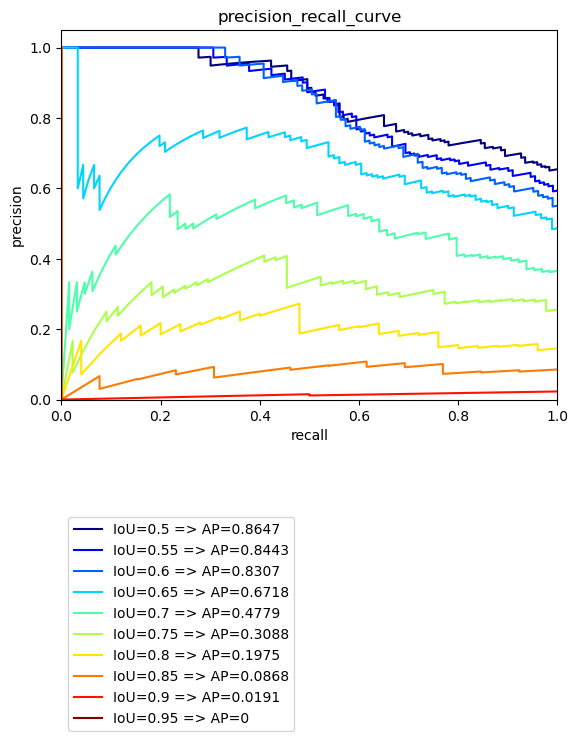

In [15]:
row, col = stage2_pred_result.shape
iou_thresholds = np.arange(0.5, 1.0, 0.05)      

precisions, recalls, f1s = [], [], []
y_trues  = []
y_scores = []
for iou_threshold in iou_thresholds:
    y_true   = []                # 0:無壺腹乳頭 1:有壺腹乳頭
    y_score  = []                # confidence分數
    for r in range(row):         # row: 列數
        test_img_name = stage2_pred_result.iloc[r:r+1]['test_name'][r]
        true_bbox     = stage2_pred_result.iloc[r:r+1]['true_bbox'][r]
        pred_bbox     = stage2_pred_result.iloc[r:r+1]['pred_bbox'][r]
        score         = stage2_pred_result.iloc[r:r+1]['score'][r]

        if true_bbox != 'NO' and pred_bbox != 'NO':
            ciou = get_iou(true_bbox, pred_bbox)           # 找出真實box和預測box的iou
            # ciou = calculate_ciou(true_bbox, pred_bbox)                     # 找出真實box和預測box的ciou
            
            if ciou >= iou_threshold:   # 如果>=iou，才是有預測到，TP會增加
                y_true.append(1)
                y_score.append(score)   # TP
            else:
                y_true.append(0)
                y_score.append(score)   # FP
        # elif true_bbox != 'NO' and pred_bbox == 'NO':   # FN
        #     y_true.append(1)
        #     y_score.append(score)
        elif true_bbox == 'NO' and pred_bbox != 'NO':  # FP   因為stage 1 完美，所以不會有這裡的FP
            y_true.append(0)
            y_score.append(score)

    y_trues.append(y_true)
    y_scores.append(y_score)

plt_precision_recall_curve_2(iou_thresholds, y_trues, y_scores)     # 畫PR curve

In [16]:
stage2_pred_result.head()

,test_name,true_bbox,pred_bbox,score
0,h_000048.png,"(432, 24, 659, 281)","(359, 64, 728, 560)",0.482020
1,h_000049.png,"(273, 19, 529, 297)","(161, 0, 726, 631)",0.482890
2,h_000050.png,"(202, 99, 442, 358)","(163, 24, 500, 513)",0.500046
3,h_000051.png,"(139, 288, 367, 573)","(184, 0, 697, 556)",0.444331
4,h_000053.png,"(113, 259, 359, 560)","(96, 182, 422, 585)",0.402671


# stage1 & stage2 測試結果

### stage1 分類預測結果

In [17]:
# stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_train.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_validation.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_test.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!
stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_test_nosmooth.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [18]:
filter1 = stage1_pred_result['test_true']!=0 
filter2 = stage1_pred_result['stage1_test_pred']!=0
stage1_pred_result_all = stage1_pred_result[(filter1 | filter2)]
print(stage1_pred_result_all.shape)
stage1_pred_result_all.head(2)

(225, 3)


,test_name,test_true,stage1_test_pred
4,h_000047_copy.png,0,1
8,h_000058.png,0,1


In [19]:
'''這6個(FP)score，不能是0，因為FP要用到score，所以要預測bbox & score'''

filter3 = stage1_pred_result['test_true']==0 
filter4 = stage1_pred_result['stage1_test_pred']==1
fp_temp_df = stage1_pred_result[(filter3 & filter4)]

row_, col_ = fp_temp_df.shape

pred_bboxes_names_  = []
pred_bboxes_scores_ = []
pred_bboxes_list_   = []
for r in range(row_):
    test_img_name = fp_temp_df.iloc[r:r+1]['test_name'].values[0]
    print(test_img_name)

    # test_img_path = "../../classification/dataset_smooth_22video_20221031/test/0/" + test_img_name
    test_img_path = "../../classification/dataset_22video_20221031/test/0/" + test_img_name
    output_img, detections = model.predict(img_path=test_img_path, 
                                           random_color=False, # 框顏色
                                           plot_img=False, # 顯示出框選圖片
                                           show_text=True, # 框上面加上類別文字
                                           box_num=1,      # 顯示框的數量
                                           return_output=True)
    
    limit = 1 #len(detections['score'])                            # 這邊要修改無限制 / 限制數量1個  !!!!!!!!!!!
    pred_box_num = len(detections['score'])  
    print("pred_box_num= ",pred_box_num)                    
    if pred_box_num > 0:       # 有預測出box
        for i in range(limit):
            score = detections[i:i+1]['score'].to_numpy()[0]
            print("score = ",score)
            if score >= 0.0:                                        # 這邊放寬score限制，看混淆矩陣狀況 !!!!!!!!!!! 
                pred_bboxes_names_.append(test_img_name)
                pred_bboxes_scores_.append(score)
                pred_bboxes_list_.append(tuple(detections[i:i+1][['x1','y1','x2','y2']].to_numpy()[0]))

            else:
                pred_bboxes_names_.append(test_img_name)
                pred_bboxes_scores_.append(score)
                pred_bboxes_list_.append('NO')
    else:
        pred_bboxes_names_.append(test_img_name)
        pred_bboxes_scores_.append(0.0)
        pred_bboxes_list_.append('NO')
        print('沒有預測出來有box(label)')

h_000047_copy.png
1/1 [==============================] - 0s 35ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.4492328
h_000058.png
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.30336145
z_000008_copy.png
1/1 [==============================] - 0s 35ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.4316715
q_000024.png
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.44880927
q_000027.png
1/1 [==============================] - 0s 35ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.45177814
h_000047.png
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.4492328
h_000057_copy.png
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.4195245
q_000031.png
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.57000995
h_000058_copy.png
1/1 [==============================

In [20]:
FP_df = pd.DataFrame({"test_name":pred_bboxes_names_, 
                      "pred_bbox":pred_bboxes_list_,
                      "score":pred_bboxes_scores_}
                      )
pred_bboxes = pd.concat([pred_bboxes,FP_df],axis=0,ignore_index=True)

In [21]:
pred_bboxes

,test_name,pred_bbox,score
0,h_000048.png,"(359, 64, 728, 560)",0.482020
1,h_000049.png,"(161, 0, 726, 631)",0.482890
2,h_000050.png,"(163, 24, 500, 513)",0.500046
3,h_000051.png,"(184, 0, 697, 556)",0.444331
4,h_000053.png,"(96, 182, 422, 585)",0.402671
...,...,...,...
220,q_000022_copy.png,"(58, 0, 595, 442)",0.281347
221,q_000028_copy.png,"(137, 0, 481, 337)",0.253059
222,h_000046_copy.png,"(201, 1, 675, 514)",0.542614
223,h_000038.png,"(188, 0, 575, 760)",0.352298


In [22]:
# Left join 
result_table_all              = stage1_pred_result_all.merge(pred_bboxes, on=['test_name'], how='left').merge(true_bboxes, on=['test_name'], how='left')
result_table_all['true_bbox'] = result_table_all.apply(lambda x: 'NO' if (x.test_true==0 and x.stage1_test_pred==1) else x.true_bbox, axis=1)     # FP
result_table_all['pred_bbox'] = result_table_all.apply(lambda x: 'NO' if (x.test_true==1 and x.stage1_test_pred==0) else x.pred_bbox, axis=1)     # FN
result_table_all.shape


(225, 6)

AP==== 0.8556145980370675
AP==== 0.8409096029582093
AP==== 0.8294664034364024
AP==== 0.665486077698261
AP==== 0.4708334321150208
AP==== 0.29957201425477253
AP==== 0.2026089716750537
AP==== 0.08389909274363057
AP==== 0.015151515151515152
AP==== nan
Averaged_AP=  0.4264


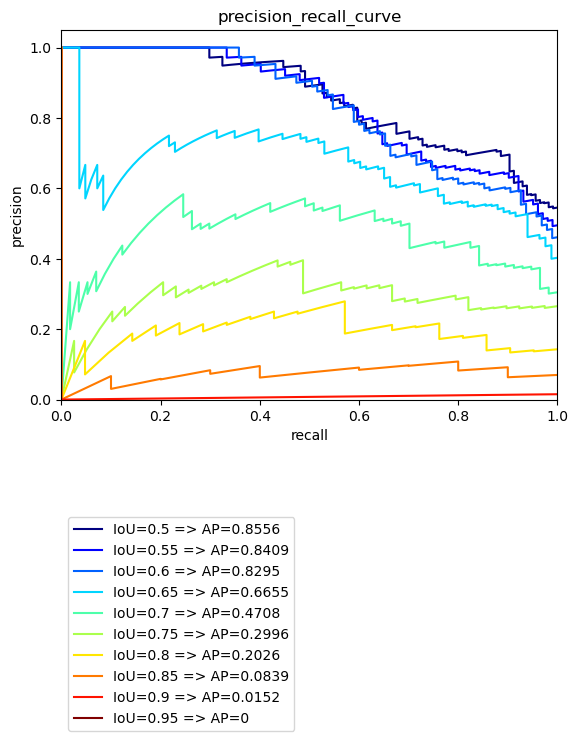

In [23]:
row, col = result_table_all.shape
iou_thresholds = np.arange(0.5, 1.0, 0.05)      

precisions, recalls, f1s = [], [], []
y_trues  = []
y_scores = []
for iou_threshold in iou_thresholds:
    y_true   = []                # 0:無壺腹乳頭 1:有壺腹乳頭
    y_score  = []                # confidence分數
    for r in range(row):         # row: 列數
        test_img_name = result_table_all.iloc[r:r+1]['test_name'][r]
        true_bbox     = result_table_all.iloc[r:r+1]['true_bbox'][r]
        pred_bbox     = result_table_all.iloc[r:r+1]['pred_bbox'][r]
        score         = result_table_all.iloc[r:r+1]['score'][r]

        # print(true_bbox, pred_bbox)
        if true_bbox != 'NO' and pred_bbox != 'NO':
            ciou = get_iou(true_bbox, pred_bbox)           # 找出真實box和預測box的iou
            # ciou = calculate_ciou(true_bbox, pred_bbox)      # 找出真實box和預測box的ciou
            
            if ciou >= iou_threshold:   # 如果>=iou，才是有預測到，TP會增加
                y_true.append(1)
                y_score.append(score)   # TP
            else:
                y_true.append(0)
                y_score.append(score)   # FP
        # elif true_bbox != 'NO' and pred_bbox == 'NO':
        #     y_true.append(1)
        #     y_score.append(0)       # FN
        elif true_bbox == 'NO' and pred_bbox != 'NO':
            y_true.append(0)
            y_score.append(score)       # FP

    y_trues.append(y_true)
    y_scores.append(y_score)

plt_precision_recall_curve_2(iou_thresholds, y_trues, y_scores)     # 畫PR curve

In [24]:
# result_table_all.to_csv("../result_df/test_stage1Andstage2_result_nosmooth.csv", index=False)